In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

from NN_jax import *

import jPCA

In [30]:
def get_reg(X_train,y_train,X_test, y_test):
    regr = RidgeCV()
    reg = regr.fit(X_train, y_train)   
    return reg.score(X_test, y_test), reg.predict(X_test)   

def get_r2_results(behaviour, ds, lag = 5, psth = True): 
    ls_r2_ksca = []
    ls_su_ksca = []
    ls_r2_sca = []
    ls_su_sca = []
    ls_r2_pca = []
    ls_su_pca = []
    ls_traces_ksca = []
    ls_traces_sca = []
    ls_traces_pca = []
    ls_principal_angle_kSCA_SCA = []
    ls_principal_angle_kSCA_PCA = []
    ls_principal_angle_SCA_PCA = []
    for d in ds:
        if psth:
            split = 20
            Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_gaussian.npy")
            Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_linear.npy")
            Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_{d}d.npy")
        else:
            split = 200
            Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_spikes/projection_{d}d_gaussian.npy")
            Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_spikes/projection_{d}d_linear.npy")
            Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_spikes/Y_pca_{d}d.npy") 
        
        y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
        y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

        X_train = Y_kSCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_kSCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)

        ls_r2_ksca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_ksca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_ksca.append( compute_S_all_pairs(jnp.array(Y_kSCA)))

        X_train = Y_SCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_SCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_sca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_sca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_sca.append( compute_S_all_pairs(jnp.array(Y_SCA)))

        
        
        X_train = Y_PCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_PCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_pca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_pca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_pca.append( compute_S_all_pairs(jnp.array(Y_PCA)))


        Q_Y_kSCA, _ = qr(Y_kSCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_SCA, _ = qr(Y_SCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_PCA, _ = qr(Y_PCA.swapaxes(1,2).reshape(-1,d))
        ls_principal_angle_kSCA_SCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_SCA))[-1] )
        ls_principal_angle_kSCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_PCA))[-1] )
        ls_principal_angle_SCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_SCA, Q_Y_PCA))[-1] )

    if psth:
        X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
    else:
        X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
    X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    r2_X = get_reg(X_train,y_train,X_test, y_test)[0]
    return ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA, ls_traces_ksca, ls_traces_sca, ls_traces_pca

def get_r2_plots(title, ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ds):
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].plot(ls_r2_ksca, label='kSCA')
    axs[0].plot(ls_r2_sca, label='SCA')
    axs[0].plot(ls_r2_pca, label='PCA')
    axs[0].set_title(title)

    axs[0].axhline(r2_X, color='black', linestyle='--')
    axs[0].set_ylabel(r"$R^2$")

    axs[1].plot(ls_su_ksca, label='kSCA')
    axs[1].plot(ls_su_sca, label='SCA')
    axs[1].plot(ls_su_pca, label='PCA')
    axs[1].set_ylabel(r"$S[\phi(U)]$")

    data_length = len(ds) 
    tick_positions = np.linspace(0, data_length - 1, num=len(ds)) 
    tick_labels = ds
    for ax in axs:
        ax.set_xlabel(r"$d$")
        ax.set_xticks(tick_positions, tick_labels)
        ax.grid()
        ax.spines[['right', 'top']].set_visible(False)

    plt.legend()
    #plt.suptitle(title)



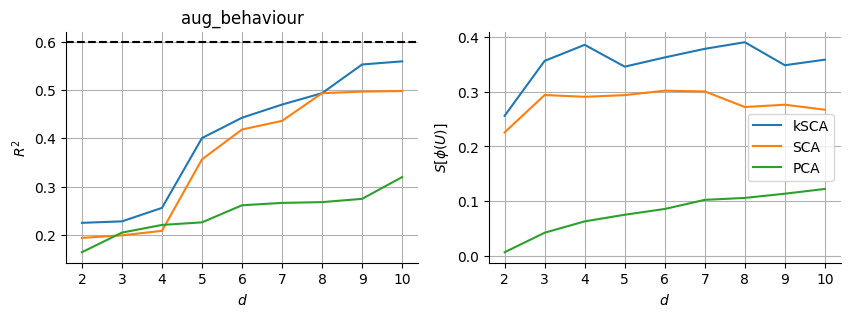

In [31]:


ds = np.arange(2,11)
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_behavior.npy' 

#path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/aug_behaviour.npy'
behaviour = np.load(path).swapaxes(1,2)
ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA, ls_traces_ksca, ls_traces_sca, ls_traces_pca = get_r2_results(behaviour, ds, psth=False)
get_r2_plots('aug_behaviour', ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ds)

In [32]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/spikes_hand_vel'

np.save(f'{main_path}/ls_r2_pca', ls_r2_pca)
np.save(f'{main_path}/ls_r2_sca', ls_r2_sca)
np.save(f'{main_path}/ls_r2_ksca', ls_r2_ksca)
np.save(f'{main_path}/r2_X', r2_X)

np.save(f'{main_path}/ls_su_pca', ls_su_pca)
np.save(f'{main_path}/ls_su_sca', ls_su_sca)
np.save(f'{main_path}/ls_su_ksca', ls_su_ksca)

np.save(f'{main_path}/ls_principal_angle_kSCA_SCA', ls_principal_angle_kSCA_SCA)
np.save(f'{main_path}/ls_principal_angle_kSCA_PCA', ls_principal_angle_kSCA_PCA)
np.save(f'{main_path}/ls_principal_angle_SCA_PCA', ls_principal_angle_SCA_PCA)

np.save(f'{main_path}/ls_traces_pca', ls_traces_pca)
np.save(f'{main_path}/ls_traces_sca', ls_traces_sca)
np.save(f'{main_path}/ls_traces_ksca', ls_traces_ksca)


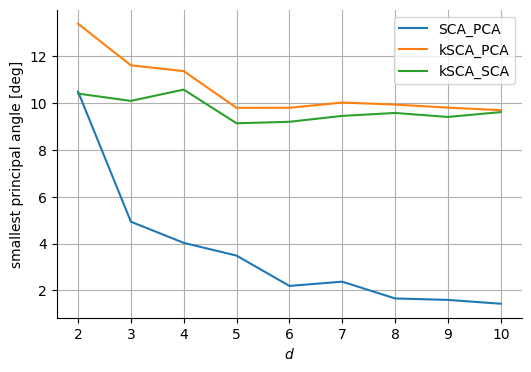

In [8]:
ds = np.arange(2, 11)
data_length = len(ds)
tick_positions = np.linspace(0, data_length - 1, num=9)
tick_labels = ds

fig, ax = plt.subplots(figsize=(6,4))  
ax.plot(ls_principal_angle_SCA_PCA, label='SCA_PCA') 
ax.plot(ls_principal_angle_kSCA_PCA, label='kSCA_PCA')
ax.plot(ls_principal_angle_kSCA_SCA, label='kSCA_SCA')

ax.legend() 
ax.set_xticks(tick_positions)  
ax.set_xticklabels(tick_labels) 
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('smallest principal angle [deg]')
ax.set_xlabel(r"$d$")
ax.grid()

In [ ]:
K, _, T = behaviour.shape
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

y_test_reshaped = y_test.reshape(split,T-lag,-1)                    #(K[test], T_lag, N)
traces_sca_reshaped = ls_traces_sca[-1].reshape(split,T-lag,-1)
print(y_test_reshaped.shape)

plt.plot(y_test_reshaped[5,:,-1])
plt.plot(traces_sca_reshaped[5,:,-1])

Neural Network Predictions

<Figure size 640x480 with 0 Axes>

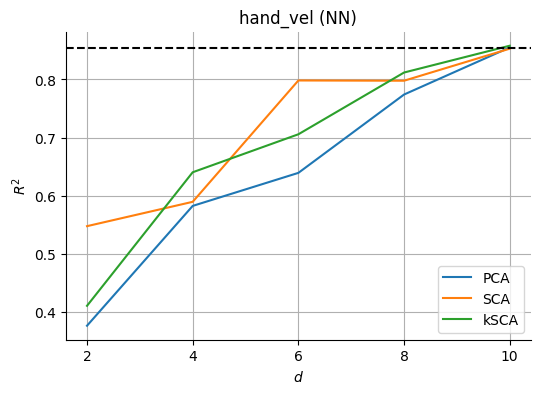

<Figure size 640x480 with 0 Axes>

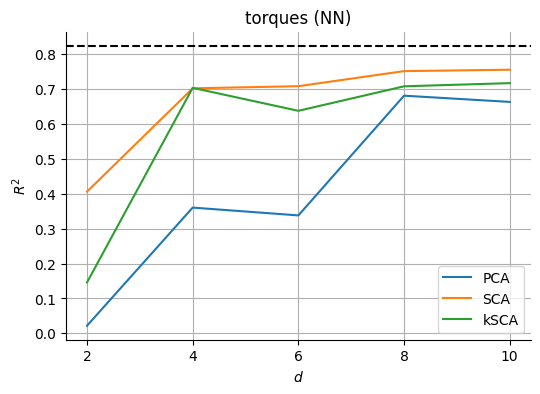

<Figure size 640x480 with 0 Axes>

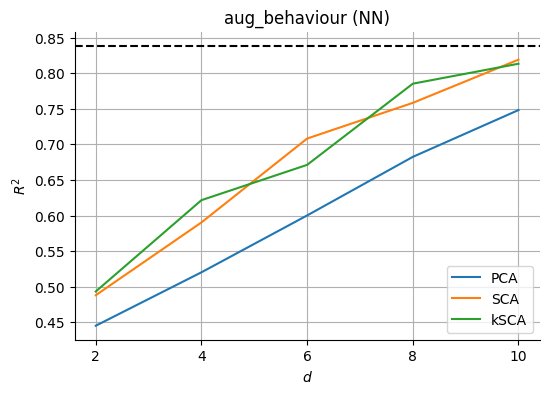

In [3]:
def get_R2_nonlinear(behaviour, ds):
    ls_r2_ksca = []
    ls_r2_sca = []
    ls_r2_pca = []
    for d in ds:
        ls_r2_ksca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/gaussian_{d}_r2 .npy'))
        ls_r2_sca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/linear_{d}_r2 .npy'))
        ls_r2_pca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/pca_{d}_r2 .npy'))


    data_length = len(ds)
    tick_positions = np.linspace(0, data_length - 1, num=5)
    tick_labels = ds

    plt.figure()
    fig, ax = plt.subplots(figsize=(6,4))  
    ax.plot(ls_r2_pca, label='PCA') 
    ax.plot(ls_r2_sca, label='SCA') 
    ax.plot(ls_r2_ksca, label='kSCA') 

    neural_r2 = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/neural_r2.npy')
    ax.axhline(neural_r2, linestyle='--', color='black')

    ax.legend() 
    ax.set_xticks(tick_positions)  
    ax.set_xticklabels(tick_labels) 
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel(r"$R^2$")
    ax.set_xlabel(r"$d$")
    ax.set_title(f'{behaviour} (NN)')
    ax.grid()

ds = [2, 4, 6, 8, 10] #np.arange(2,11)
get_R2_nonlinear('hand_vel', ds)
get_R2_nonlinear('torques', ds)
get_R2_nonlinear('aug_behaviour', ds)

ENDS HERE 

In [14]:
split = 10 
lag = 5


behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/aug_behaviour.npy')
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])


#X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_3d_gaussian.npy")
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

r2 = np.array(get_reg(X_train,y_train,X_test, y_test)[0])
print(r2)



# X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_10d_linear.npy")
# X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
# X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

# print(get_reg(X_train,y_train,X_test, y_test)[0])

0.8558503794645321


In [16]:
params, ls_loss = optimize(X_train, y_train, layer_sizes = [182, 10, 6], num_iterations = 10000, seed=42, learning_rate = 1e-2)

Iter 1, Loss: 0.1831
Iter 11, Loss: 0.1510
Iter 21, Loss: 0.0920
Iter 31, Loss: 0.0593
Iter 41, Loss: 0.0464
Iter 51, Loss: 0.0345
Iter 61, Loss: 0.0257
Iter 71, Loss: 0.0207
Iter 81, Loss: 0.0174
Iter 91, Loss: 0.0157
Iter 101, Loss: 0.0146
Iter 111, Loss: 0.0138
Iter 121, Loss: 0.0132
Iter 131, Loss: 0.0127
Iter 141, Loss: 0.0122
Iter 151, Loss: 0.0118
Iter 161, Loss: 0.0115
Iter 171, Loss: 0.0113
Iter 181, Loss: 0.0110
Iter 191, Loss: 0.0107
Iter 201, Loss: 0.0105
Iter 211, Loss: 0.0104
Iter 221, Loss: 0.0105
Iter 231, Loss: 0.0102
Iter 241, Loss: 0.0099
Iter 251, Loss: 0.0098
Iter 261, Loss: 0.0097
Iter 271, Loss: 0.0096
Iter 281, Loss: 0.0095
Iter 291, Loss: 0.0094
Iter 301, Loss: 0.0093
Iter 311, Loss: 0.0093
Iter 321, Loss: 0.0092
Iter 331, Loss: 0.0091
Iter 341, Loss: 0.0090
Iter 351, Loss: 0.0090
Iter 361, Loss: 0.0089
Iter 371, Loss: 0.0088
Iter 381, Loss: 0.0088
Iter 391, Loss: 0.0087
Iter 401, Loss: 0.0089
Iter 411, Loss: 0.0088
Iter 421, Loss: 0.0086
Iter 431, Loss: 0.0086

In [17]:
predictions = predict(params, X_test)
r2 = r2_score(y_test, predictions)
print(r2)
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/aug_behaviour/neural_r2', r2)

0.8384948231050885


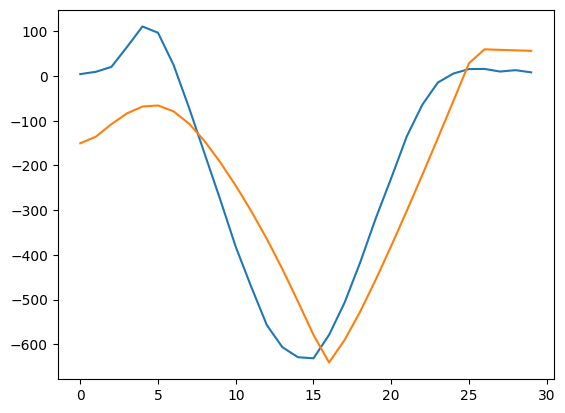

In [23]:
T=35
y_test_reshaped = y_test.reshape(split,T-lag,-1)                    #(K[test], T_lag, N)
pred_reshaped = predictions.reshape(split,T-lag,-1)

plt.plot(y_test_reshaped[7,:,0])
plt.plot(pred_reshaped[7,:,0])